# depth losses analysis script

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

from oceantracker.post_processing.read_output_files import load_output_files 
from oceantracker.util.polygon_util import InsidePolygon
# from oceantracker.post_processing.plotting import plot_statistics
# from oceantracker.post_processing.plotting import stats_plot 


In [2]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v09'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)


In [3]:
# observational polygons in which to calculate concentrations
observational_polygone = [
    {
        'name': 'pre-splitting',
        'points': np.array([
           [572085,5922830],
           [572169,5922719],
           [572246,5922848],
           [572162,5922948] 
        ])
    },
    # norderelbe
    ## low-depth
    {
        'name': 'norder-bunthaus',
        'points': np.array([
            [570470,5925498],
            [570537,5925521],
            [570508,5925681],
            [570433,5925668]
        ])
    },
    {
        'name': 'norder-kaltehofe',
        'points': np.array([
            [569021,5931319],
            [569084,5931274],
            [569139,5931362],
            [569077,5931410]
        ])
    },
    ## medium-depth
    {
        'name': 'norder-elphi',
        'points': np.array([
            [565158,5932675],
            [565229,5932795],
            [565151,5932838],
            [565069,5932716]
        ])
    },
    ## high-depth
    {
        'name': 'norder-dockland',
        'points': np.array([
            [562387,5933002],
            [562390,5932860],
            [562513,5932872],
            [562507,5933012]
        ])
    },
    # suederelbe
    ## low-depth
    {
        'name': 'sueder-bunthaus',
        'points': np.array([
            [570405,5923818],
            [570454,5923894],
            [570397,5923946],
            [570345,5923871]
        ])
    },
    {
        'name': 'sueder-eurpabruecke',
        'points': np.array([
            [565993,5925470],
            [566099,5925433],
            [566083,5925340],
            [565977,5925374]
        ])
    },
    ## medium depth
    {
        'name': 'sueder-nynas',
        'points': np.array([
            [563601,5926690],
            [563675,5926768],
            [563630,5926837],
            [563552,5926761]
        ])
    },
    ## high depth
    {
        'name': 'sueder-kohlbrandt',
        'points': np.array([
            [562176,5931052],
            [562290,5931042],
            [562293,5931190],
            [562180,5931192]
        ])
    },
    # post sueder-norder unification
    {
        'name': 'post-unification',
        'points': np.array([
            [560484,5932946],
            [560485,5932765],
            [560640,5932764],
            [560637,5932946]
        ])
    }
]

In [10]:
# load grid
grid = load_output_files.load_grid(cases[0])
# load concentration field
concentration = load_output_files.load_concentration_vars(
            cases[0], var_list=['pzzarticle_concentration'])


In [11]:
# for each obs poly create a InsidePolygon object
# with this object we extract the triangles of the grid which are part of the polygon
# with the subsets of triangles we can calculate the concentration in the polygon (and reduce data size)

# create InsidePolygon objects
for poly in observational_polygone:
    poly['InsidePolygon'] = InsidePolygon(poly['points'])

# get triangles of grid which are part of the polygon

# get triangles of grid
triangles = grid['triangles']
# nodes of triangles
x = grid['x']

for poly in observational_polygone:
    print(poly['name'])
    poly['triangles'] = []

    for ii,tri in enumerate(triangles):
        if ii%1000 == 0: print(ii)
        nodes = x[tri]
        # check if triangle is part of polygon

        if poly['InsidePolygon'].is_inside(nodes).any():
            poly['triangles'].append(ii)

    poly['triangles'] = np.array(poly['triangles'])
    print(poly['triangles'])
        
    

    

pre-splitting
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
[7724 7725 7726 7746 7747 7748 7749 7750 7751 7752 7754 7768 7769 7770
 7771 7772 7773 7774 7777 7780 7797 7798 7799 7800]
norder-bunthaus
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
[9272 9273 9274 9275 9279 9280 9288 9319 9320 9321 9322 9323 9324 9325
 9326 9327 9336 9365 9366 9367 9368 9369]
norder-kaltehofe
0
1000
2000

In [6]:
for poly in observational_polygone:
    if len(poly['triangles']) > 0:
        poly['concentration'] = np.average(concentration['particle_concentration'][:,poly['triangles']],axis=1)
    else:
        poly['concentration'] = np.full(concentration['particle_concentration'].shape[0],np.nan)

# create a pandas df with concentration data
import pandas as pd

df = pd.DataFrame()
for poly in observational_polygone:
    df[poly['name']] = poly['concentration']
df['time'] = concentration['time']

# transform time from posix to datetime
df['time'] = pd.to_datetime(df['time'],unit='s')



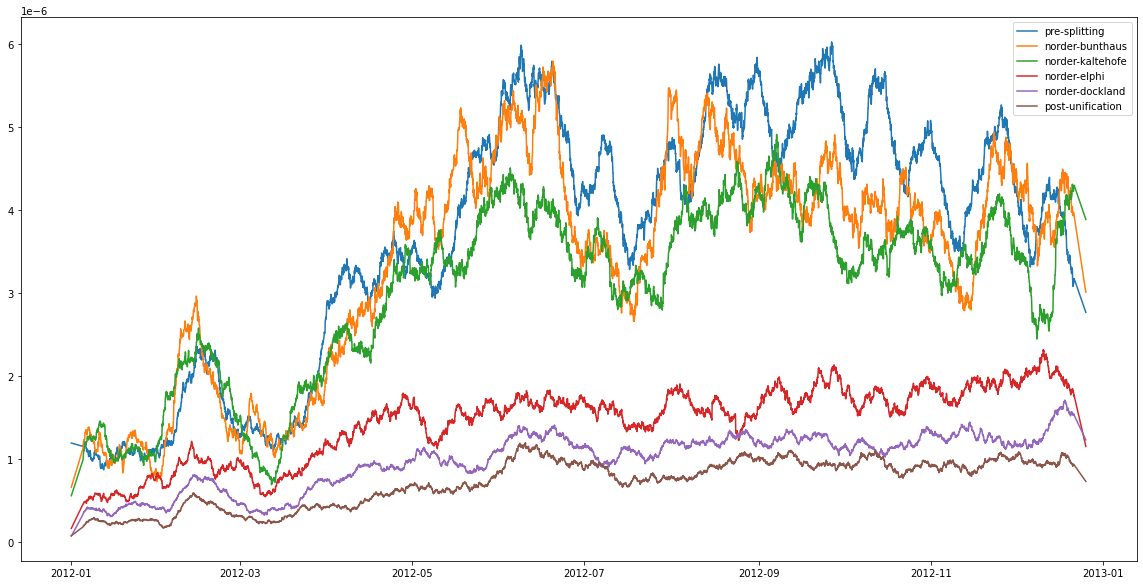

In [7]:
# same as above with a low pass filter (savitzky golay)
from scipy.signal import savgol_filter

filter_window = 201

plt.figure(figsize=(20,10))
plt.plot(df['time'],savgol_filter(df['pre-splitting'],filter_window,1),label='pre-splitting')

# plot all polies with norder in name
for keys in df.keys():
    if 'norder' in keys:
        plt.plot(df['time'],savgol_filter(df[keys],filter_window,1),label=keys)

plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1),label='post-unification')
plt.legend()


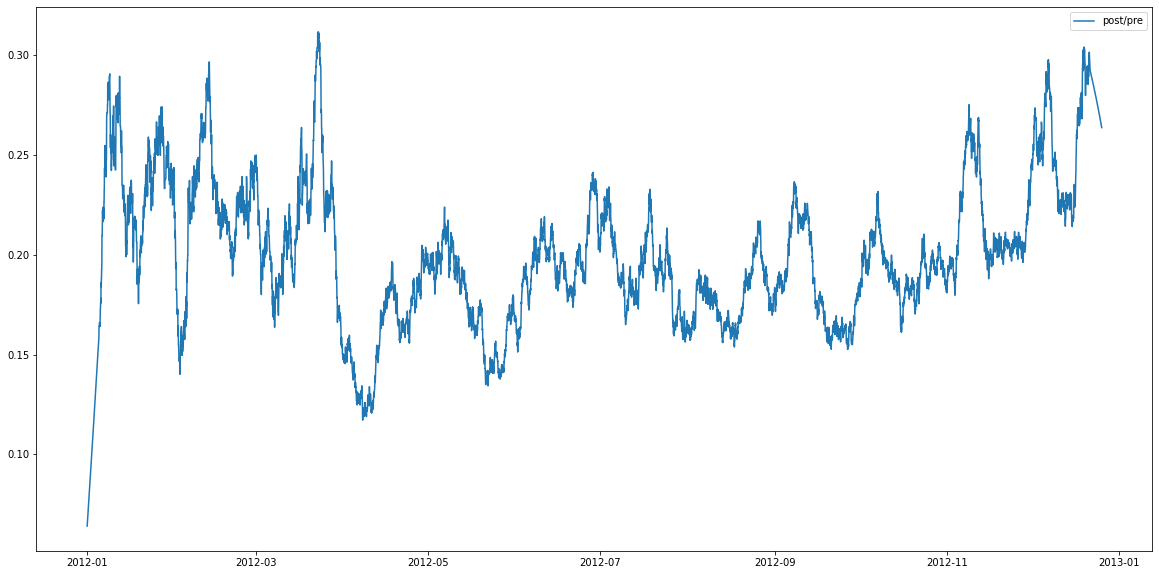

In [8]:
# plot post relative to pre
plt.figure(figsize=(20,10))

plt.plot(df['time'],savgol_filter(df['post-unification'],filter_window,1)/savgol_filter(df['pre-splitting'],filter_window,1),label='post/pre')

plt.legend()


In [9]:
from netCDF4 import Dataset

# temp open file
data =  Dataset('/scratch/local1/hzg2/schout_11.nc')
salt = data.variables['salt'][:].filled(0)


In [13]:
salt.shape

(24, 32432, 21)

In [18]:
np.max(np.max(salt[:,:,:],axis=2),axis=0).shape

(32432,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
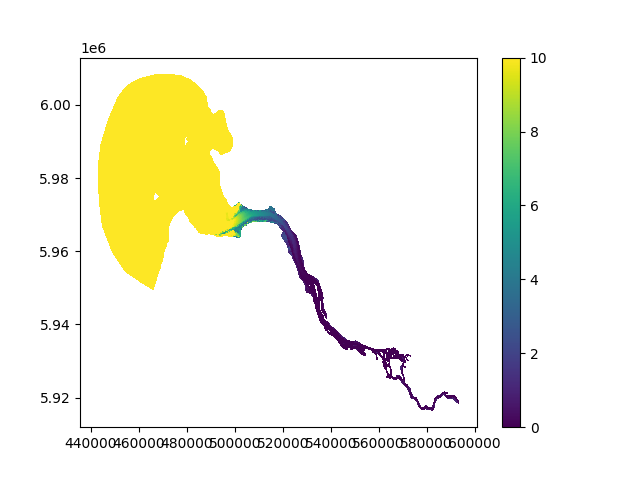

In [19]:
%matplotlib widget
plt.tripcolor(grid['x'][:,0],grid['x'][:,1],grid['triangles'],np.max(np.max(salt[:,:,:],axis=2),axis=0),shading='flat')
# set color range from 0 to 1
plt.clim(0,10)
plt.colorbar()

In [30]:
# tracks
tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

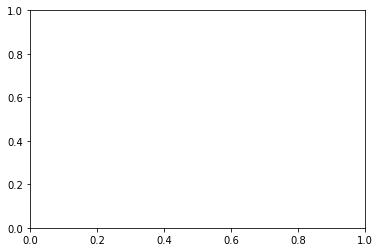

In [4]:
from oceantracker.post_processing.plotting.plot_tracks import plot_tracks

In [5]:
plot_tracks(tracks,show_start=True)

NameError: name 'tracks' is not defined

In [ ]:
observational_polygone[-1]['InsidePolygon'].is_inside(x)

In [21]:
sliced_tracks = tracks['x'][np.where(tracks['status'] > 0)]
sliced_tracks = sliced_tracks[:,:]

In [22]:
sliced_tracks = sliced_tracks[observational_polygone[-1]['InsidePolygon'].is_inside(sliced_tracks)]

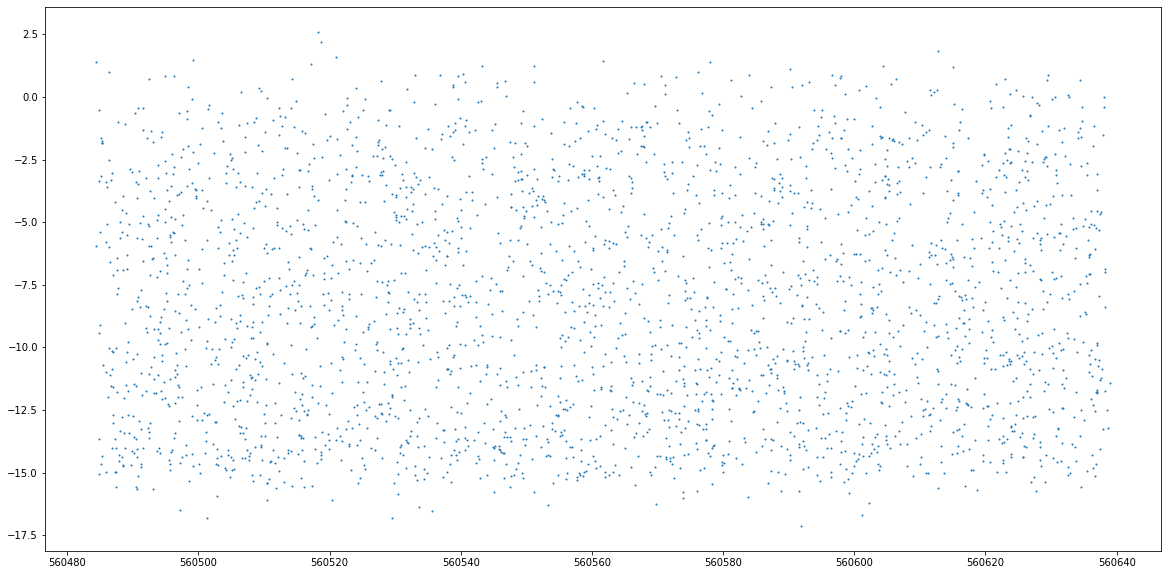

In [26]:
plt.figure(figsize=(20,10))
plt.scatter(sliced_tracks[:,0],sliced_tracks[:,2],s=1)

In [39]:
x = tracks['x'][np.where(tracks['status'] > 0)]
x.shape

(37787318, 3)

In [37]:
bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom.shape

(37787318,)

In [46]:
from copy import deepcopy


(z - surface) / (-bottom - surface) = relative_depth
-1.62 - 1.5 / -16.69 - 1.5 = 0.17
-3.12 / -15.19 = 0.17


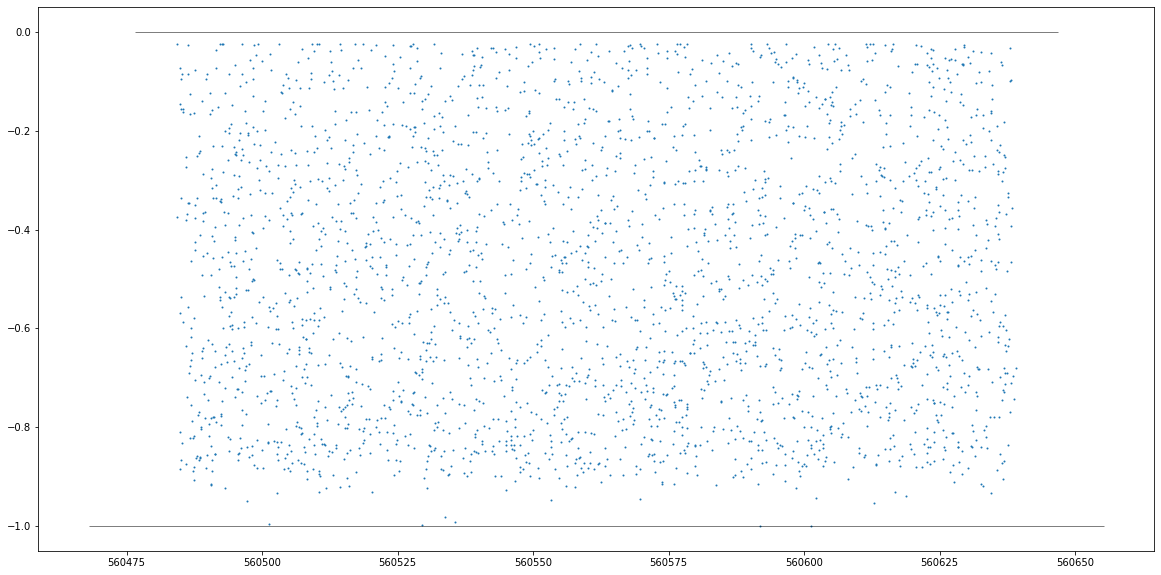

In [65]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[-1]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# scale vertical position linearly with 0 at surface and 1 at bottom
relative_depth = (z - surface)/(-bottom - surface)

# print an example of this equation with values for index ii
#(z - surface)/(-bottom - surface)

ii = 1
print('(z - surface) / (-bottom - surface) = relative_depth')
print(f'{round(z[ii],2)} - {round(surface[ii],2)} / -{round(bottom[ii],2)} - {round(surface[ii],2)} = {round(relative_depth[ii],2)}')
# simplify equation 
print(f'{round(z[ii] - surface[ii],2)} / -{round(bottom[ii] - surface[ii],2)} = {round(relative_depth[ii],2)}')


plt.figure(figsize=(20,10))
plt.scatter(x[:,0],-relative_depth,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)

(z - surface) / (-bottom - surface) = relative_depth
-3.19 - 2.84 / -5.72 - 2.84 = 0.71
-6.04 / -2.87 = 0.71


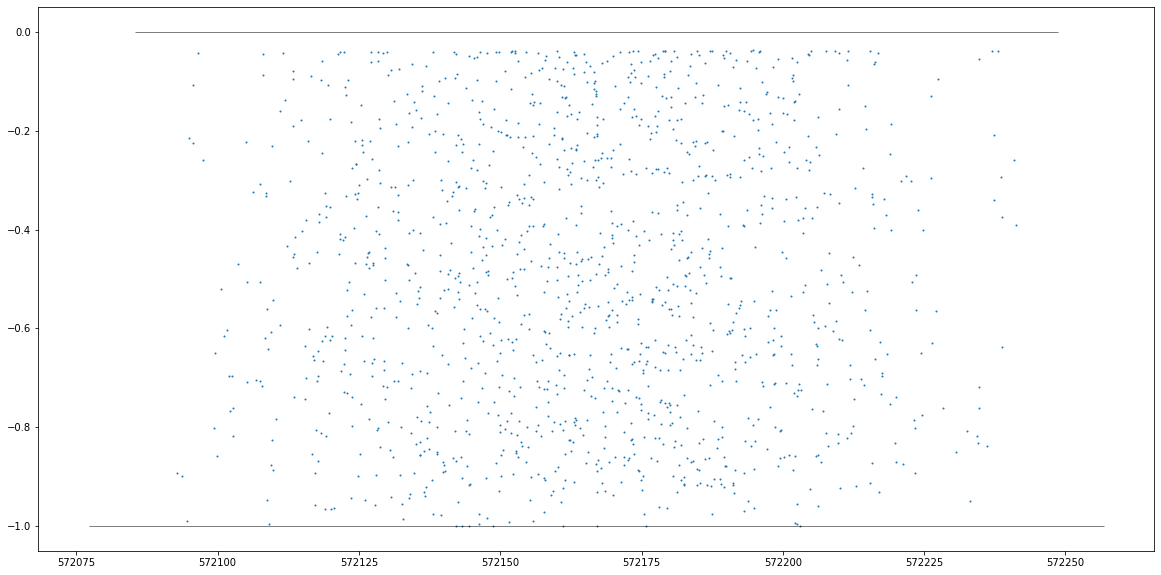

In [66]:
# rescale depth to relative from surface to bottom
x = tracks['x'][np.where(tracks['status'] > 0)]
inside = deepcopy(observational_polygone[0]['InsidePolygon'].is_inside(x))
x = x[inside]
z = x[:,2]

bottom = tracks['water_depth']
bottom = bottom[np.where(tracks['status'] > 0)]
bottom = bottom[inside]

surface = tracks['tide']
surface = surface[np.where(tracks['status'] > 0)]
surface = surface[inside]

# scale vertical position linearly with 0 at surface and 1 at bottom
relative_depth = (z - surface)/(-bottom - surface)

# print an example of this equation with values for index ii
#(z - surface)/(-bottom - surface)

ii = 1
print('(z - surface) / (-bottom - surface) = relative_depth')
print(f'{round(z[ii],2)} - {round(surface[ii],2)} / -{round(bottom[ii],2)} - {round(surface[ii],2)} = {round(relative_depth[ii],2)}')
# simplify equation 
print(f'{round(z[ii] - surface[ii],2)} / -{round(bottom[ii] - surface[ii],2)} = {round(relative_depth[ii],2)}')


plt.figure(figsize=(20,10))
plt.scatter(x[:,0],-relative_depth,s=1)
plt.hlines(0,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)
plt.hlines(-1,plt.xlim()[0],plt.xlim()[1],color='k',linewidth=0.5)